In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2242_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2242_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 715
inactives: 183379


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

# sampling random examples from the inactives
inactives_train = inactives_train.sample(n=415, random_state=42)

In [5]:
df = pd.concat([actives_train, inactives_train], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,0,2,0,2,0,0,0,0,0,0,...,0,1,0,0,0,4.85798,-0.806583,0.000000,2.846540,0
1,0,0,0,1,0,0,0,0,0,0,...,0,2,0,0,0,4.24793,-0.100701,0.000000,0.436691,0
2,0,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,4.39200,-0.521000,0.000000,-0.698000,1
3,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.32193,-0.682781,0.387097,2.778200,0
4,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,4.90700,-0.787000,0.000000,1.816000,1


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    415
1    415
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

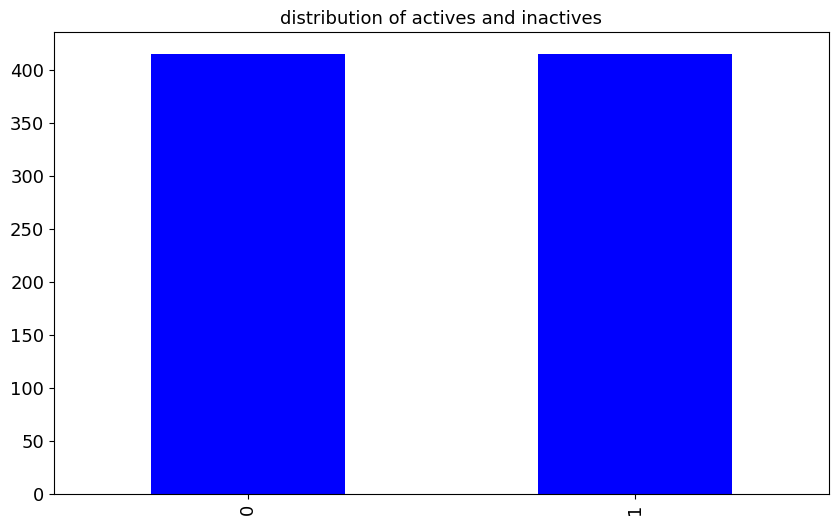

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validate = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((821, 598), (9, 598))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

0    413
1    413
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

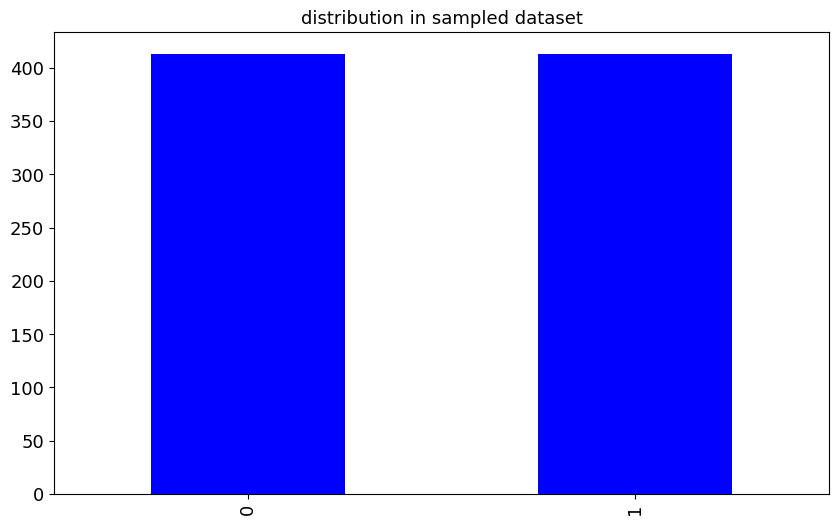

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
logistic_reg = LogisticRegression(solver='saga', max_iter=50, random_state=42, verbose=1, class_weight={0: 1, 1: 1.44})
logistic_reg.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(class_weight={0: 1, 1: 1.44}, max_iter=50, random_state=42,
                   solver='saga', verbose=1)

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,4.954,-0.280,0.231,3.149,1
1,1,0,0,2,2,0,0,0,0,0,...,0,1,0,0,1,5.285,-0.234,0.214,0.636,1
2,2,0,0,2,2,0,0,0,0,0,...,0,2,0,0,0,5.170,-0.658,0.444,3.317,1
3,2,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.170,-0.823,0.444,3.307,1
4,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,4.858,-0.717,0.000,1.820,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D003,D004,D005,D006,D012,D013,D014,D015,...,D764,D765,D768,D770,D771,D773,D774,D775,D776,D777
0,-0.364659,-0.101264,-0.06056,0.230651,0.698145,-0.131713,-0.913701,1.114124,-1.085431,-1.119434,...,-0.034922,-1.077402,-0.134161,-0.539873,-0.187907,-0.140981,-0.313362,0.883145,-0.335731,0.853940
1,-0.364659,-0.101264,-0.06056,1.623037,-0.355489,-0.131713,0.465248,1.114124,-0.780038,-0.903746,...,-0.034922,0.877398,-0.134161,1.362426,-0.187907,7.093130,0.481007,1.025885,-0.443270,-1.157526
2,0.903922,-0.101264,-0.06056,1.623037,-0.355489,-0.131713,0.695073,0.672668,-0.474644,-0.532763,...,-0.034922,0.877398,-0.134161,3.264724,-0.187907,-0.140981,0.205018,-0.289802,1.011662,0.988411
3,0.903922,-0.101264,-0.06056,1.623037,-0.355489,-0.131713,0.695073,-0.210242,-0.780038,-0.851981,...,-0.034922,-0.100002,-0.134161,-0.539873,-0.187907,-0.140981,0.205018,-0.801803,1.011662,0.980407
4,-1.633240,-0.101264,-0.06056,0.230651,-1.409124,-0.131713,-1.373350,-1.093153,0.746931,1.304898,...,-0.034922,-1.077402,-0.134161,1.362426,-0.187907,-0.140981,-0.543753,-0.472881,-1.796989,-0.209824


In [26]:
logistic_reg.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
logistic_reg.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.85

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = logistic_reg.predict_proba(testing_data_x)[:, 1]
y_pred_rounded = (y_pred > 0.5).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [33]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.85
precision is 0.8453947368421053
recall is 0.8566666666666667
f1 is 0.8509933774834437
